# Code

## Standard imports

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

import time
np.random.seed(int(time.time()))

## Specific imports

In [15]:
import sys
sys.path.insert(1, '../sglv_timeseries')

import sglv_timeseries.ibm.Timeseries as ibm
import sglv_timeseries.glv.Timeseries as glv
from sglv_timeseries.noise_parameters import NOISE
from sglv_timeseries.models import MODEL
from sglv_timeseries.timeseries_plotting import PlotTimeseries, PlotRankAbundance

from scipy import stats

from itertools import count

from heavytails import fit_heavytail, plot_heavytail, normalizations, plot_cdf_heavytail
from scipy.optimize import curve_fit

from variation import variation_coefficient, JS

import warnings

from matplotlib.collections import LineCollection

from elife_settings import ELIFE, set_elife_settings

set_elife_settings()

## Random paramaters and example plot functions

In [9]:
def random_parameter_set(S, connectance=0.3, minint=-0.5, maxint=0.5,
                         minmigration=0.4, maxmigration=0.4,
                         minextinction=0.5, maxextinction=0.5, growth_rate=1.5):
    interaction = np.random.uniform(minint, maxint, [S, S])
    interaction *= np.random.choice([0, 1], interaction.shape, p=[1 - connectance, connectance])  # connectance
    np.fill_diagonal(interaction, -1.)  # self-interaction

    growth_rate = np.full([S, 1], growth_rate)
    immigration = np.random.uniform(minmigration, maxmigration, [S, 1])
    extinction = np.random.uniform(minextinction, maxextinction, [S, 1])

    params = {'interaction_matrix': interaction, 'immigration_rate': immigration,
              'extinction_rate': extinction, 'growth_rate': growth_rate}

    return params

def random_parameter_set_ibm(S, connectance=0.3, minint=-0.5, maxint=0.5,
                         minmigration=0.4, maxmigration=0.4,
                         minextinction=0.5, maxextinction=0.5, growth_rate=1.5):
    
    interaction = np.random.uniform(minint, maxint, [S, S])
    interaction *= np.random.choice([0, 1], interaction.shape, p=[1 - connectance, connectance])  # connectance
    np.fill_diagonal(interaction, -1.)  # self-interaction

    growth_rate = np.full([S, 1], growth_rate)
    immigration = np.random.uniform(minmigration, maxmigration, [S, 1])
    extinction = np.random.uniform(minextinction, maxextinction, [S, 1])

    SIS = []
    SISfactor = 200

    SISvector = np.ones(S, dtype=int)
    SISvector[SIS] *= SISfactor

    params = {'interaction_matrix' : interaction, 'immigration_rate' : immigration, 
             'extinction_rate' : extinction,
               'growth_rate' : growth_rate, 'SIS':SIS, 'SISvector':SISvector}

    return params


def random_parameter_set_logistic(S, width_growth=1):
    growth_rate = stats.lognorm.rvs(loc=0, s=width_growth, size=[S, 1])
    if np.sqrt(4 - width_growth ** 2) == 0:
        self_int = np.ones(S)
    else:
        self_int = stats.lognorm.rvs(loc=0, s=np.sqrt(4 - width_growth ** 2), size=S)

    interaction = np.zeros([S, S])
    np.fill_diagonal(interaction, -self_int)  # self-interaction

    growth_rate = np.full([S, 1], growth_rate)
    immigration = np.zeros([S, 1])
    extinction = np.zeros([S, 1])

    params = {'interaction_matrix': interaction, 'immigration_rate': immigration,
              'extinction_rate': extinction, 'growth_rate': growth_rate}

    return params

In [10]:
def example_timeseries(connectance, immigration, int_strength, noise=None, 
                       max_cap=None, sites=None, S=200, 
                       noise_implementation=NOISE.LANGEVIN_LINEAR):
    
    if sites == None:
        params = random_parameter_set(S, 
           minmigration=immigration, maxmigration=immigration, connectance=connectance,
           minint=-int_strength, maxint=int_strength)
        
        if np.isinf(max_cap):
            model = MODEL.GLV
            params['initial_condition'] = np.random.uniform(0, 1, [S,1])
        else:
            model = MODEL.MAX
            params['maximum_capacity'] = max_cap
            initcond = np.random.uniform(0, 1, [S,1])
            params['initial_condition'] = initcond*max_cap/S
        if noise_implementation == NOISE.LANGEVIN_LINEAR:
            params['noise_linear'] = noise
        elif noise_implementation == NOISE.LANGEVIN_SQRT:
            params['noise_sqrt'] = noise
        elif noise_implementation == NOISE.LANGEVIN_CONSTANT:
            params['noise_constant'] = noise
        
    elif sites != None and max_cap == None:
        params = random_parameter_set_ibm(S,
           minmigration=immigration, maxmigration=immigration, 
                                          connectance=connectance,
           minint=-int_strength, maxint=int_strength)
    
        model = MODEL.IBM
        params['initial_condition'] = np.random.randint(0, int(0.66*sites/S), S)
        params['sites'] = sites
    return show_example(params, model, noise_implementation)

def example_timeseries_logistic(width_growth, noise, S=200):
    params = random_parameter_set_logistic(S, width_growth)

    #interaction_SIS = add_SIS(interaction, SISvector)
    initcond = np.random.uniform(0, 1, [S,1])
    
    params = {'interaction_matrix' : interaction, 'immigration_rate' : immigration, 
            'extinction_rate' : extinction, 'initial_condition' : initcond, 
            'noise_linear' : noise, 'growth_rate' : growth_rate}
    
    return show_example(params, MODEL.GLV)

def show_example(params, model, noise_implementation):
    # find steady state without noise
    if model in [MODEL.GLV, MODEL.MAX]:
        params_init = params.copy()
        params_init['noise_linear'] = 0
        ts = glv.Timeseries(params_init, T = 125, dt=0.005, tskip=199, model=model)
        discrete = False
    elif model == MODEL.IBM:
        ts = ibm.Timeseries(params, T = 150)
        discrete = True
        
    stab = (np.max(np.abs((ts.timeseries.iloc[-50, 1:] - ts.timeseries.iloc[-1, 1:])/ ts.timeseries.iloc[-50, 1:])) < 0.1)
    print("Deterministic solution is stable:", stab)
    #if stab == False:
    #    print(ts.timeseries.iloc[0,:])
    #    print(ts.timeseries.iloc[1,:])
    ep = ts.endpoint
    col_to_drop = ep.index[ep.endpoint < 1e-6*np.max(ep.endpoint)]
    
    PlotTimeseries(ts.timeseries.drop(columns=col_to_drop))

    if model in [MODEL.GLV, MODEL.MAX]:
        params['initial_condition'] = ts.endpoint.values.astype('float')
        ts = glv.Timeseries(params, T = 250, dt=0.005, tskip=199, model=model, noise_implementation=noise_implementation)
    elif model == MODEL.IBM:
        params['initial_condition'] = ts.endpoint.values.astype('int').flatten()
        ts = ibm.Timeseries(params, T = 250)
    PlotTimeseries(ts.timeseries.drop(columns=col_to_drop))
    params = variation_coefficient(ts.timeseries)
    print("variation:", params[0])
    params = JS(ts.timeseries, verbose=True)
    print("JS:", params[0])
    print("pval stable (higher more stable):", params[-1])
    
    ep = ts.endpoint.values.astype('float').flatten()
    ep = ep[ep > 1e-6*np.max(ep)]
    
    print("remaining species", len(ep))
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    print("things", ep[0], ep[-1], len(ep), discrete)
    params = fit_heavytail(ep, func='lognorm', discrete=discrete)
    plot_heavytail(ep, params, func='lognorm', ax=ax, discrete=discrete)
    print("Width lognorm:", params[0], params[1], params[2])
    print("Stat lognorm:", params[-2])
    for f in ['expon', 'norm', 'powerlaw', 'pareto']:
        params = fit_heavytail(ep, func=f, discrete=discrete)
        plot_heavytail(ep, params, func=f, ax=ax, discrete=discrete)
        print("Stat %s:" % f, params[-2])
    params = fit_heavytail(ep, func='trunc_powerlaw', discrete=discrete)
    plot_heavytail(ep, params, func='trunc_powerlaw', ax=ax, discrete=discrete)
    print("Stat trunc powerlaw:", params[-2])
    print("R powerlaw (negative -> lognormal):", params[2])
    
    return ep

# Introduction

In experimental data, we can find a power law relation between the diversity (number of different species) and the complexity (number and strength of interactions).

Solé 2002 can reproduce such a law with an IBM.

We verify the results for our implementation of an IBM and for gLV models.

# Diversity-complexity

In [12]:
def widths(df, func='log'):
    var = 'log_width' if func == 'log' else \
          'pow_a' if func == 'pow' else \
          'norm_scale' if func == 'nrom' else ''

    funcs = ['pow', 'tpow', 'pareto', 'log', 'norm']

    d = df[[col for col in df.columns if col.startswith(var)]].copy()

    for j in range(1, 11):
        for f in funcs:
            if f != func:
                d[var + '_%d' % j][df[func + '_pval_%d' %
                                      j] < df[f + '_pval_%d' % j]] = np.nan

    d.replace(0, np.nan, inplace=True)

    d_accepted = d.copy()

    for j in range(1, 11):
        d_accepted[var + '_%d' % j][df[func + '_pval_%d' % j] < 0.05] = np.nan

    return d.mean(axis=1), d_accepted.mean(axis=1)


def spec_div_ax(df_input, ax, ax2, fixed_pars={}, label=None, color='k', 
                not_accepted=False, accepted=True):
    df = df_input.copy()

    for param, value in fixed_pars.items():
        df = df[df[param] == value]
    
    df['x'] = df.connectance * df.interaction**2

    numbers = df[[
        col for col in df.columns if col.startswith('number')]].copy()
    numbers.replace(0, np.nan, inplace=True)
    df['y'] = numbers.median(axis=1)
    df.loc[np.isnan(df.y), 'y'] = 0

    df['w'], df['w_accepted'] = widths(df, func='log')

    if not ax == None:
        ax.scatter(df['x'], df['y'], label=label, alpha=0.3, color=color)
    if not ax2 == None:
        if not_accepted:
            ax2.scatter(df['x'], df['w'], label=label,
                        alpha=0.3, s=0.5, color=color)
        ax2.scatter(df['x'], df['w_accepted'], label=label,
                    alpha=0.3, s=5, color=color)

    return df['x'], df['y'], df['w']


def fit_slope_spec_div(x, y, xmin, ax, color='k',
                       label={'x': 0.95, 'y': 0.05, 'ha': 'right', 'va': 'bottom'}):
    def power_law_f(x, a, b):
        return a*x**b

    xdata = x[x > xmin]
    ydata = y[x > xmin]

    if len(xdata) == 0:
        return

    p, cov = curve_fit(f=power_law_f, xdata=xdata, ydata=ydata,
                       p0=[0, 0], bounds=(-np.inf, np.inf))

    xx = np.linspace(0, 1, 200)
    l = ax.plot(xx, power_law_f(xx, p[0], p[1]), color=color)
    color = l[0].get_color()

    ax.text(label['x'], label['y'], 'slope %.2f $\pm$ %.2f' % (p[1], np.sqrt(cov[1, 1])),
            transform=ax.transAxes, color=color, ha=label['ha'], va=label['va'])
    return

0.5    881
Name: noise, dtype: int64


findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.


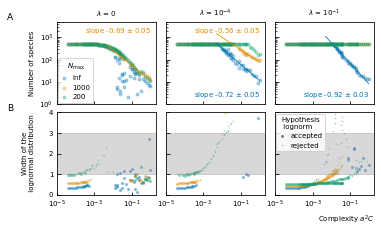

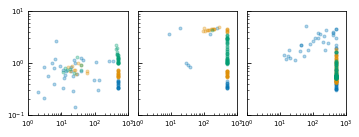

In [13]:
def figure_specdiv_glv(df):
    var = 'immigration'
    vals = [0, 1e-4, 1e-1]
    cutoffs = [[np.nan, 5e-2, np.nan], # immigration = 0 (maxcaps [np.inf, 1000, 200])
               [1e-2, 5e-2, np.nan], # immigration = 1e-4 (maxcaps [np.inf, 1000, 200])
               [1e-2, np.nan, np.nan]] # immigration = 1e-1 (maxcaps [np.inf, 1000, 200])
    labels = ['$\lambda$ = 0', '$\lambda$ = $10^{-4}$', '$\lambda$ = $10^{-1}$']
    #xmin1=5e-2; xmin1immi=5e-2
    
    maxcaps = [np.inf,1000,200]
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    fig = plt.figure(figsize=(ELIFE.TEXTWIDTH, 3))
    gs = gridspec.GridSpec(2,len(vals), hspace=0.1, wspace=0.1, 
                           top=0.92, bottom=0.12, left=0.15, right=0.95)

    figb = plt.figure(figsize=(ELIFE.TEXTWIDTH, 1.8))
    gsb = gridspec.GridSpec(1,len(vals), hspace=0.1, wspace=0.1, 
                           top=0.92, bottom=0.12, left=0.15, right=0.95)

    axes = [fig.add_subplot(gs[0])]
    axes2 = [fig.add_subplot(gs[len(vals)], sharex=axes[0])]
    axesb = [figb.add_subplot(gsb[0])]

    for i in range(1, len(vals)):
        axes = np.append(axes, fig.add_subplot(gs[i], sharey=axes[0]))
        axes2 = np.append(axes2, fig.add_subplot(gs[len(vals)+i], sharex=axes[i], sharey=axes2[0]))

        axesb = np.append(axesb, figb.add_subplot(gsb[i], sharey=axesb[0]))

    for i, ax, ax2, axb, val, label in zip(
        count(), axes, axes2, axesb, vals, labels):
        ax.set_title(label)
    
        dfi = df[df[var] == val]
        
        for j, maxcap, color, loc_label, label_y in zip(
            count(), maxcaps, colors, ['bottom', 'top', None], [0.05, 0.95, np.nan]):
            
            x, y, w = spec_div_ax(dfi, ax, ax2, fixed_pars={'max_cap' : maxcap}, label=maxcap, color=color, 
                                  not_accepted=True)
            
            axb.scatter(y, w, label=maxcap, alpha=0.3, color=color)
            
            fit_slope_spec_div(x, y, cutoffs[i][j], ax, color,
                   label={'x' : 0.95, 'y' : label_y, 'ha' : 'right', 'va' : loc_label})
        
        ax.set_xscale('log')
        ax.set_yscale('log')
        axb.set_xscale('log')
        axb.set_yscale('log')
        ax.tick_params(labelbottom=False)
        if i > 0:
            ax.tick_params(labelleft=False)
            ax2.tick_params(labelleft=False)
            axb.tick_params(labelleft=False)

        ax.set_xlim([1e-5,2])
        ax.set_ylim([1e0,5e3])
        ax2.set_ylim([0,4])
        ax2.axhspan(1, 3, color='grey', alpha=0.3)
        axb.set_xlim([1e0,1e3])
        axb.set_ylim([1e-1,10])

    from matplotlib.lines import Line2D

    legend_elements = [Line2D([0], [0], marker='o', color='none', label='accepted',
                          markerfacecolor='grey', markeredgecolor='none', markersize=3),
                   Line2D([0], [0], marker='o', color='none', label='rejected',
                          markerfacecolor='grey', markeredgecolor='none', markersize=1),]
    axes2[-1].legend(title='Hypothesis\n lognorm', handles=legend_elements, loc=2)

    axes2[-1].set_xlabel('Complexity $a^2C$', x=1, ha='right')
    axes[0].set_ylabel('Number of species')
    axes2[0].set_ylabel('Width of the\n lognormal distribution')
    axes[0].legend(title='$N_\mathrm{max}$', loc=3)

    axes[0].text(-0.5, 1.02, 'A', transform = axes[0].transAxes, size=9, ha='left')
    axes2[0].text(-0.5, 1.02, 'B', transform = axes2[0].transAxes, size=9, ha='left')
    fig.align_labels()

    return fig

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    df1 = pd.read_csv('results/scan_glv_diversity500.csv', na_values='NAN')
    df2 = pd.read_csv('results/scan_glv_diversity20.csv', na_values='NAN')
    df = pd.concat([df1, df2], axis=0, ignore_index=True)
    
    fig = figure_specdiv_glv(df)
    
    #fig.savefig('figures/complexity_stability_glv.pdf')



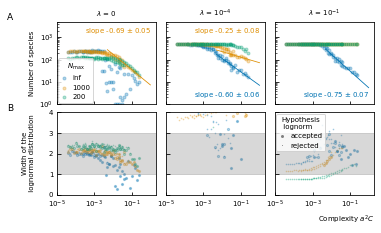

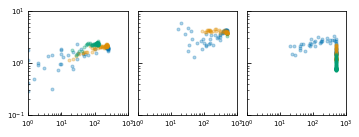

In [221]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    df = pd.read_csv('results/scan_diversity_glvlog.csv', na_values='NAN')
    
    fig = figure_specdiv_glv(df)

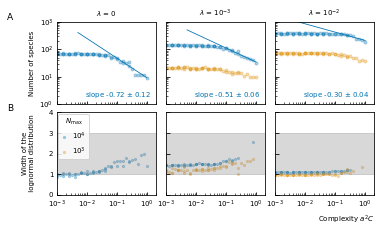

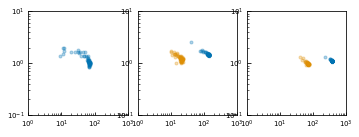

In [29]:
def figure_specdiv_ibm():
    df = pd.read_csv('results/scan_diversity_ibm500.csv', na_values='NAN')
    
    var = 'immigration'
    vals = [0, 1e-3, 1e-2]
    labels = ['$\lambda$ = $0$', '$\lambda$ = $10^{-3}$', '$\lambda$ = $10^{-2}$']
    cutoff=1e-1;
    
    sitess = [10000, 1000]
    sites_labels = ['$10^4$', '$10^3$']
    
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    fig = plt.figure(figsize=(ELIFE.TEXTWIDTH, 3))
    gs = gridspec.GridSpec(2,len(vals), hspace=0.1, wspace=0.1, 
                           top=0.92, bottom=0.12, left=0.15, right=0.95)

    figb = plt.figure(figsize=(ELIFE.TEXTWIDTH, 1.8))
    gsb = gridspec.GridSpec(1,len(vals), hspace=0.1, wspace=0.1, 
                           top=0.92, bottom=0.12, left=0.15, right=0.95)

    axes = [fig.add_subplot(gs[0])]
    axes2 = [fig.add_subplot(gs[len(vals)], sharex=axes[0])]
    axesb = [figb.add_subplot(gsb[0])]

    for i in range(1, len(vals)):
        axes = np.append(axes, fig.add_subplot(gs[i], sharey=axes[0]))
        axes2 = np.append(axes2, fig.add_subplot(gs[len(vals)+i], sharex=axes[i], sharey=axes2[0]))

        axesb = np.append(axesb, figb.add_subplot(gsb[i], sharey=axesb[0]))

    for i, ax, ax2, axb, val, label in zip(
        count(), axes, axes2, axesb, vals, labels):
        ax.set_title(label)
    
        dfi = df[df[var] == val]
        
        for sites, label, color in zip(sitess, sites_labels, colors):
            x, y, w = spec_div_ax(dfi, ax, ax2, {'sites' : sites}, label, color)
            
            axb.scatter(y, w, label=label, alpha=0.3, color=color)
            
            if sites == sitess[0]:
                fit_slope_spec_div(x, y, cutoff, ax, color, 
                       label={'x' : 0.95, 'y' : 0.05, 'ha' : 'right', 'va' : 'bottom'})
        
        ax.set_xscale('log')
        ax.set_yscale('log')
        #ax2.set_yscale('log')
        ax.tick_params(labelbottom=False)
        
        ax.set_xscale('log')
        ax.set_yscale('log')
        axb.set_xscale('log')
        axb.set_yscale('log')
        ax.tick_params(labelbottom=False)
        if i > 0:
            ax.tick_params(labelleft=False)
            ax2.tick_params(labelleft=False)

        ax.set_xlim([1e-3,2])
        ax.set_ylim([1e0,1e3])
        
        ax2.set_ylim([0, 4])
        ax2.axhspan(1, 3, color='grey', alpha=0.3)
        
        axb.set_xlim([1e0,1e3])
        axb.set_ylim([1e-1,10])

    axes2[-1].set_xlabel('Complexity $a^2C$', x=1, ha='right')
    axes[0].set_ylabel('Number of species')
    axes2[0].set_ylabel('Width of the\n lognormal distribution')
    axes2[0].legend(title='$N_\mathrm{max}$')

    axes[0].text(-0.5, 1.02, 'A', transform = axes[0].transAxes, size=9, ha='left')
    axes2[0].text(-0.5, 1.02, 'B', transform = axes2[0].transAxes, size=9, ha='left')
    fig.align_labels()

    return fig

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fig = figure_specdiv_ibm()
    
    #plt.savefig('figures/complexity_stability_ibm.pdf')

# Only one steady state

Can there be multiple steady states for the model (gLV with immigration) depending on the initial conditions? We show the steady state of 5 time series with the same parameters with different initial conditions where species are set to zero at random. 

As can be seen from the figure underneath, the initial condition is unimportant for the steady state.

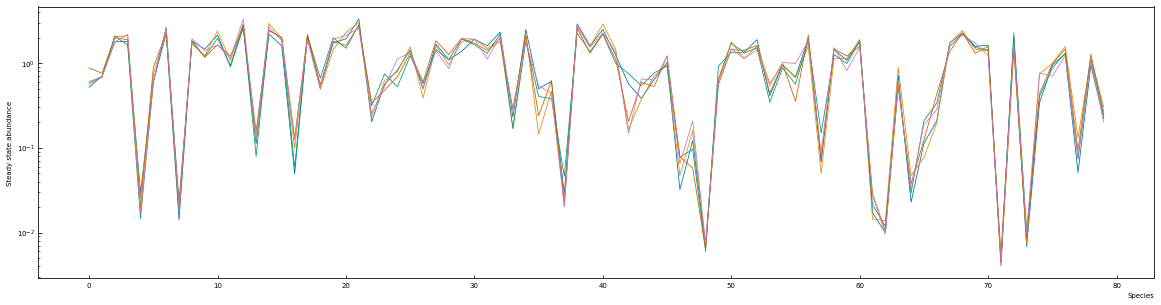

In [75]:
S = 80
perc_zero = 0.99

model = MODEL.GLV

params = random_parameter_set(S, connectance=0.1, minint=-0.5, maxint=0.5,
                         minmigration=0.01, maxmigration=0.01,
                         minextinction=0.5, maxextinction=0.5, growth_rate=1.5)

params['noise_linear'] = 0.2

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)

for i in range(5):
    params['initial_condition'] = ( np.random.uniform(0, 10, [S, 1]) * 
                                    np.random.choice([0., 1.], size=[S,1], p=[perc_zero, 1. - perc_zero]) )

    ts = glv.Timeseries(params, T = 250, dt=0.05, tskip=19, model=model, seed=i) 
    
    # PlotTimeseries(ts.timeseries)
    
    ep = ts.endpoint
    
    ax.plot(range(S), ep)

plt.xlabel('Species', x=1, ha='right')
plt.ylabel('Steady state abundance')
plt.yscale('log')
plt.show()

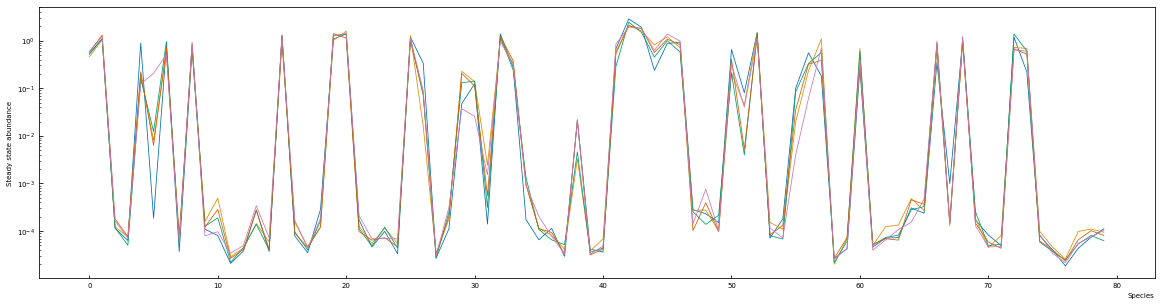

In [82]:
S = 80
perc_zero = 0.99

connectance = 0.8
interaction = 0.5
immigration = 1e-4

model = MODEL.MAX

params = random_parameter_set(S, connectance=connectance, minint=-interaction, maxint=interaction,
                         minmigration=immigration, maxmigration=immigration,
                         minextinction=0.5, maxextinction=0.5, growth_rate=1.5)

params['noise_linear'] = 0.2
params['maximum_capacity'] = S

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)

for i in range(5):
    params['initial_condition'] = ( np.random.uniform(0, 10, [S, 1]) * 
                                    np.random.choice([0., 1.], size=[S,1], p=[perc_zero, 1. - perc_zero]) )

    ts = glv.Timeseries(params, T = 250, dt=0.05, tskip=19, model=model, seed=i) 
    
    # PlotTimeseries(ts.timeseries)
    
    ep = ts.endpoint
    
    ax.plot(range(S), ep)

ax.set_xlabel('Species', x=1, ha='right')
ax.set_ylabel('Steady state abundance')
ax.set_yscale('log')
plt.show()

# Immigration pushes solution to boundary

In [ ]:
When there is no maximal capacity, the 

How many species can immigrate into system?

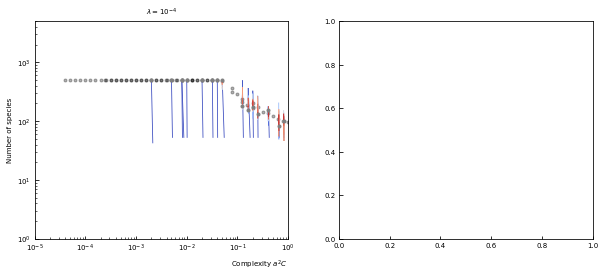

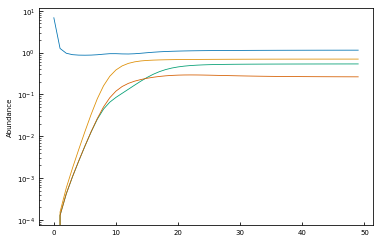

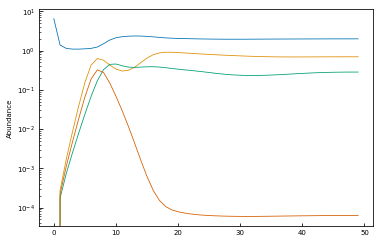

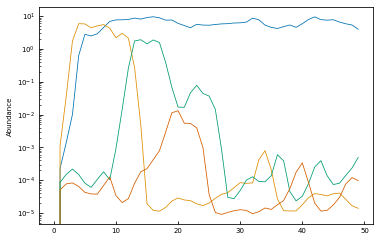

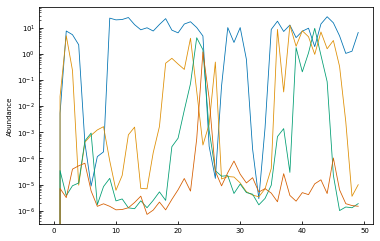

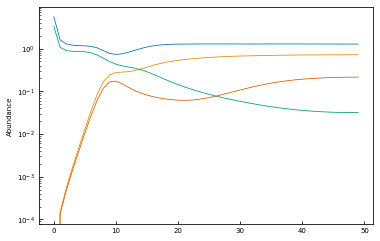

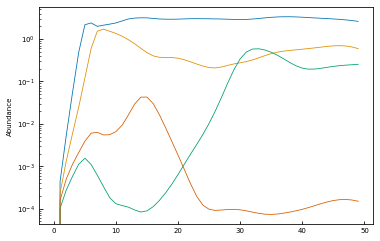

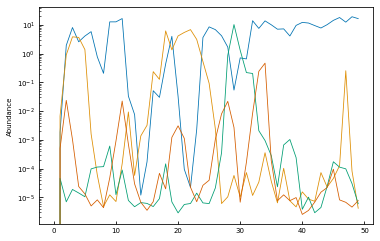

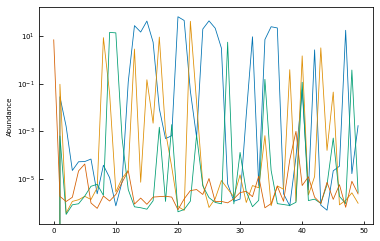

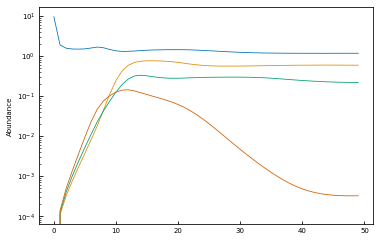

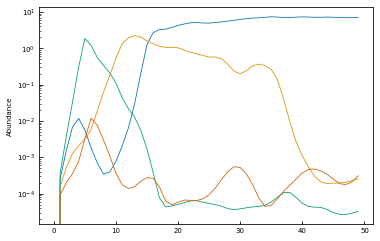

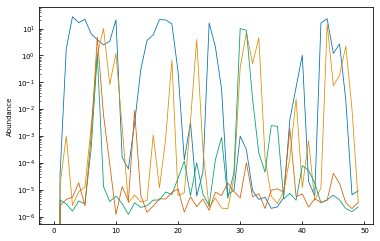

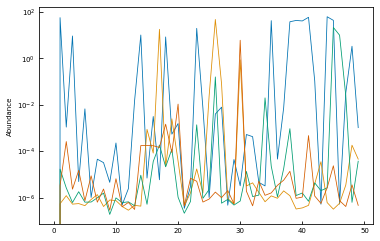

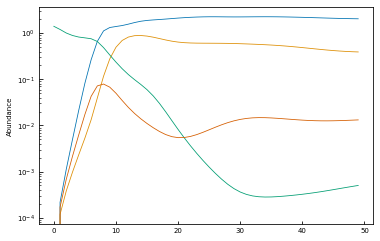

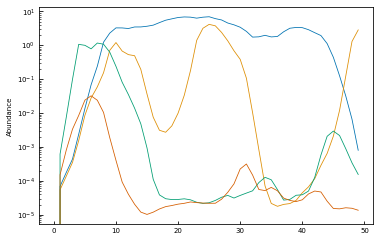

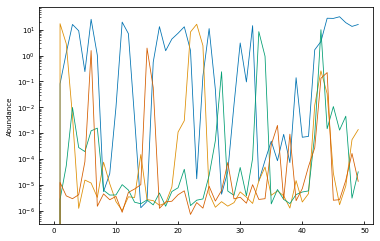

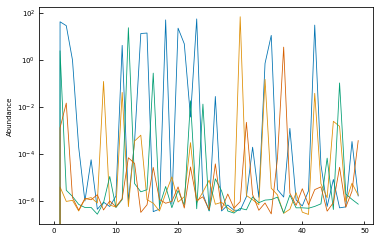

In [181]:
S = 500

def number_complexity(state, interaction_matrix):
    N = len(state)
    
    present = state > 1e-6*np.max(state)
    Np = np.sum(present)
    
    if Np == 0:
        return 0, 0
    
    present_interaction = interaction_matrix[np.ix_(present, present)]
    np.fill_diagonal(present_interaction, np.nan)
    
    connectance = np.sum(present_interaction != 0)/(Np**2 - Np)
    interaction_strength = np.nanmax(np.abs(present_interaction))
    
    complexity = connectance * interaction_strength**2
    
    return Np, complexity

def timeseries_trajectory(ax, connectance, interaction, S=200, perc_zero=0.9):
    model = MODEL.MAX

    params = random_parameter_set(S, connectance=connectance, minint=-interaction, maxint=interaction,
                             minmigration=immigration, maxmigration=immigration,
                             minextinction=0.5, maxextinction=0.5, growth_rate=1.5)

    params['noise_linear'] = 0.
    params['maximum_capacity'] = max_cap

    params['initial_condition'] = ( np.random.uniform(0, 10, [S, 1]) * 
                                    np.random.choice([0., 1.], size=[S,1], p=[perc_zero, 1. - perc_zero]) )

    ts = glv.Timeseries(params, T = 50, dt=0.005, tskip=199, model=model, seed=i).timeseries
    PlotTimeseries(ts)
    
    ts.set_index('time', inplace=True)
        
    trajectory_x = []
    trajectory_y = []
    
    for t in np.arange(0, 50, 1):
        state = ts.loc[t]
        
        N, c = number_complexity(state, params['interaction_matrix'])
        
        trajectory_x = np.append(trajectory_x, c)
        trajectory_y = np.append(trajectory_y, N)
        
    points = np.array([trajectory_x, trajectory_y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a continuous norm to map from data points to colors
    norm = plt.Normalize(0, len(points))
    lc = LineCollection(segments, cmap='coolwarm', norm=norm)
    # Set the values used for colormapping
    lc.set_array(np.arange(len(points)))
    #lc.set_linewidth(2)
    ax.add_collection(lc)
    
    ax.plot(c, N, 'o', color='grey')
    
    #ax.plot(trajectory_x, trajectory_y)
    
df1 = pd.read_csv('results/scan_glv_diversity500.csv', na_values='NAN')
df2 = pd.read_csv('results/scan_glv_diversity20.csv', na_values='NAN')
df = pd.concat([df1, df2], axis=0, ignore_index=True)

max_cap = 1000 #np.inf,200

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for ax, immigration, title in zip([ax1], [1e-4], ['$\lambda = 10^{-4}$']):
# zip([ax1, ax2], [1e-4, 1e-2], ['$\lambda = 10^{-4}$', '$\lambda = 10^{-2}$']):
    ax.set_title(title)
    dfi = df[(df['immigration'] == immigration) & (df['max_cap'] == max_cap)]

    spec_div_ax(dfi, ax, ax2=None, fixed_pars={}, label=None, color='k', not_accepted=False, accepted=True)

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim([1e-5, 1e0])
    ax.set_ylim([1e0, 5e3])

    for connectance in [0.2, 0.5, 0.8, 1.0]:
        for interaction in [0.1, 0.2, 0.5, 0.9]:
            timeseries_trajectory(ax, connectance, interaction, S=S, perc_zero=0.9)

    ax.set_xlabel('Complexity $a^2C$', x=1, ha='right')
    ax.set_ylabel('Number of species')

plt.show()

# Example timeseries

Deterministic solution is stable: False
variation: 0.8637183390925098
JS: 0.19074202029631282
pval stable (higher more stable): 0.003683262337939151
remaining species 200
things 0.0001941138183915253 0.8819757938287567 200 False
Width lognorm: 5.15305699128301 0.0 1.0
Stat lognorm: 0.2863562756802188
Stat expon: 0.3984405519673924
Stat norm: 0.22912350237537177
Stat powerlaw: 0.17036942402029967
Stat pareto: 0.6597898007576983


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


Stat trunc powerlaw: 0.4010717126068778
R powerlaw (negative -> lognormal): -22.095801517615435
179.79124509181554


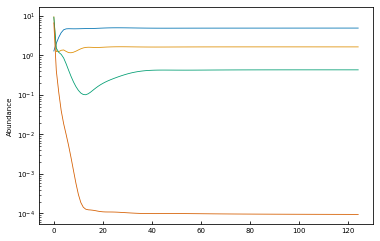

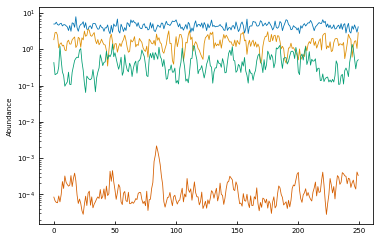

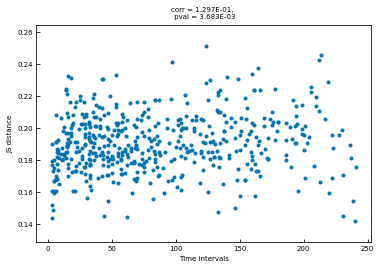

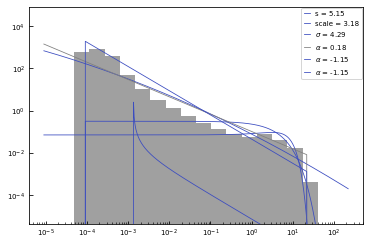

In [17]:
connectance = 0.3
immigration = 1e-4 #1e-4
int_strength = 0.3
sites = None
max_cap = 2000 #20 
S = 200
noise = 0.5 #None

ep = example_timeseries(connectance, immigration, int_strength, noise=noise, 
                       max_cap=max_cap, sites=sites, S=S, 
                   noise_implementation=NOISE.LANGEVIN_LINEAR)
print(np.sum(ep))


No handles with labels found to put in legend.


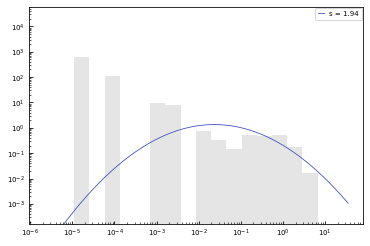

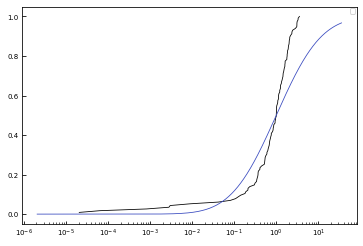

0.14523668558948188 0.0037913850700604305 115 (1.9362299944213903, 0.0, 1.0, 0.2594993583961809, 2.552775475506177e-07)


In [36]:
discrete = False
#ep = ep[ep > 1e-3*np.max(ep)]
#ep /= np.mean(ep)
func = 'lognorm'
params = fit_heavytail(ep, func=func, discrete=discrete)
plot_heavytail(ep, params, func=func, discrete=discrete)
plot_cdf_heavytail(ep, params, func=func, discrete=discrete)
plt.show()

print(ep[0], ep[-1], len(ep), params)
